In [248]:
%load_ext autoreload
import sys, os
COLAB = 'google.colab' in sys.modules 
if COLAB and 'procgen-tools' not in os.getcwd():
    os.system("git clone https://github.com/UlisseMini/procgen-tools")
    os.chdir('procgen-tools')
    %pip install -r requirements.txt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [249]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from procgen import ProcgenGym3Env
import envs.maze as maze
from models import load_policy
import torch
from IPython import display
from glob import glob
import pickle
from tqdm import tqdm
from data_util import Episode, load_episode
from metric_utils import metrics, decision_square
import os
from collections import defaultdict

import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split


In [1671]:
files = glob('data/*region_6*.pkl')
#files = glob('data/*region*.pkl')
runs = []
load_venv = False
for f in files:
    try:
        runs.append(load_episode(f, load_venv=load_venv))
    except (AssertionError, KeyError) as e:
        print(f"Malformed file {f}: {e}")
        #os.remove(f)

len(runs)

10000

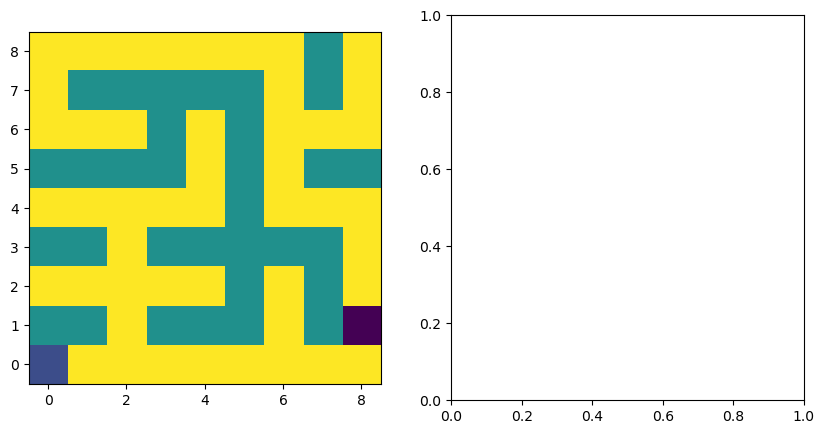

In [1672]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
R = 3
ax[0].imshow(runs[R].grid(), origin='lower')
if load_venv: ax[1].imshow(runs[R]["start_info"]["rgb"])
plt.show()

## Graph metrics on all grids

In [1674]:
recorded_metrics = defaultdict(list)
recorded_runs = []
got_cheese = []
for run in tqdm(runs):
    g = run.grid()
    if decision_square(g) is None or (g[-5:, -5:] == maze.CHEESE).any():
        continue
    for name, metric in metrics.items():
        recorded_metrics[name].append(metric(g))
    got_cheese.append(float(run.got_cheese))
    recorded_runs.append(run)

runs = recorded_runs; del recorded_runs
got_cheese = np.array(got_cheese)
len(got_cheese)

100%|██████████| 10000/10000 [04:17<00:00, 38.89it/s] 


5116

In [1675]:
for name, metric in recorded_metrics.items():
    recorded_metrics[name] = np.array(metric)

In [1676]:
prob = sum(got_cheese) / len(got_cheese)
print(f'P(get cheese | decision square, cheese not in top 5x5) = {prob}')

P(get cheese | decision square, cheese not in top 5x5) = 0.691164972634871


In [1677]:
# Use matplotlib to plot all recorded_metrics by name (key) vertically in a single figure
fig, ax = plt.subplots(len(recorded_metrics), 1, figsize=(10, 5*len(recorded_metrics)))
for i, (name, values) in enumerate(recorded_metrics.items()):
    #values = stats.zscore(values)
    bins, edges = np.histogram(values, bins=20)
    percentages = []
    for j, (num_runs_in_this_bin, edge) in enumerate(zip(bins, edges)):
        successes = sum(got_cheese[np.logical_and(values >= edges[j], values < edges[j+1])]) 
        # laplace's rule of succession avoids devision-by-zero,
        # and gives a better estimate of P(get cheese | metric in this bin).
        percentages.append((successes+1) / (num_runs_in_this_bin+2))
    ax[i].bar(edges[:-1], percentages, width=edges[1]-edges[0])
    ax[i].set_title(name)
  
plt.show()

<Figure size 1000x5000 with 10 Axes>

In [258]:
ax.ravel()[0]

<AxesSubplot:title={'center':'euc_dist_cheese_decision_square'}>

In [1705]:
recorded_metrics.items()

dict_items([('euc_dist_cheese_decision_square', array([ 2.        ,  2.82842712,  6.32455532, ...,  2.        ,
        5.65685425, 11.18033989])), ('steps_between_cheese_decision_square', array([ 2,  8,  8, ...,  2, 12, 17])), ('steps_between_cheese_top_right', array([12, 14, 40, ..., 14, 26, 29])), ('euc_dist_cheese_top_right', array([ 8.94427191,  7.21110255, 14.4222051 , ...,  7.21110255,
       10.77032961, 16.15549442])), ('euc_dist_decision_square_top_right', array([ 7.21110255,  4.47213595, 19.79898987, ...,  8.48528137,
       10.        ,  8.94427191])), ('steps_between_decision_square_top_right', array([10,  6, 32, ..., 12, 14, 12])), ('steps_between_cheese_5x5', array([ 4,  6, 36, ...,  8, 20, 25])), ('steps_between_decision_square_5x5', array([ 2,  0, 28, ...,  6,  8,  8])), ('euc_dist_cheese_5x5', array([ 4.        ,  2.        ,  8.94427191, ...,  2.        ,
        6.        , 11.18033989])), ('euc_dist_decision_square_5x5', array([ 2.        ,  0.        , 14.14213562

In [1716]:

cond = np.logical_and(
    (recorded_metrics['euc_dist_cheese_decision_square'] > 0),
    (recorded_metrics['steps_between_cheese_decision_square'] > 20),
      
) 

basenum= len (np.nonzero(cond)[0])
#cond = np.logical_and(cond,[not(runs[i].got_cheese) for i in range(len(runs))])

sp_indexes = np.nonzero(cond)[0]
filtered_rm = {}
for key, value in recorded_metrics.items():
    filtered_rm[key] = recorded_metrics[key][sp_indexes]
    
#euc_dist_cheese_decision_square, steps_between_cheese_decision_square, steps_between_cheese_top_right, euc_dist_cheese_top_right,
#euc_dist_decision_square_top_right, steps_between_decision_square_top_right, steps_between_cheese_5x5, 
#steps_between_decision_square_5x5, euc_dist_cheese_5x5, euc_dist_decision_square_5x5

In [1711]:
assert len(filtered_rm['euc_dist_cheese_decision_square']) == len(sp_indexes)

In [1734]:






scaler = StandardScaler()

data = {
'steps_between_cheese_5x5': recorded_metrics['steps_between_cheese_5x5'],
'euc_dist_cheese_5x5': recorded_metrics['euc_dist_cheese_5x5'],
'euc_dist_cheese_decision_square': recorded_metrics['euc_dist_cheese_decision_square'],
'steps_between_cheese_decision_square': recorded_metrics['steps_between_cheese_decision_square'],
'steps_between_cheese_top_right': recorded_metrics['steps_between_cheese_top_right'],
'euc_dist_cheese_top_right': recorded_metrics['euc_dist_cheese_top_right'],
'euc_dist_decision_square_top_right': recorded_metrics['euc_dist_decision_square_top_right'],
'steps_between_decision_square_top_right': recorded_metrics['steps_between_decision_square_top_right'],
'steps_between_decision_square_5x5': recorded_metrics['steps_between_decision_square_5x5'],
'euc_dist_decision_square_5x5': recorded_metrics['euc_dist_decision_square_5x5']
}

filtered_data = {
'steps_between_cheese_5x5': filtered_rm ['steps_between_cheese_5x5'],
'euc_dist_cheese_5x5': filtered_rm ['euc_dist_cheese_5x5'],
'euc_dist_cheese_decision_square': filtered_rm ['euc_dist_cheese_decision_square'],
'steps_between_cheese_decision_square': filtered_rm ['steps_between_cheese_decision_square'],
'steps_between_cheese_top_right': filtered_rm ['steps_between_cheese_top_right'],
'euc_dist_cheese_top_right': filtered_rm ['euc_dist_cheese_top_right'],
'euc_dist_decision_square_top_right': filtered_rm ['euc_dist_decision_square_top_right'],
'steps_between_decision_square_top_right': filtered_rm ['steps_between_decision_square_top_right'],
'steps_between_decision_square_5x5': filtered_rm['steps_between_decision_square_5x5'],
'euc_dist_decision_square_5x5': filtered_rm ['euc_dist_decision_square_5x5']
} 

#data= scaler.transform(data)


df = pd.DataFrame(data) 

filtered_df= pd.DataFrame(filtered_data) 

df= stats.zscore(df)

filtered_df= stats.zscore(filtered_df)

df ['cheese'] = pd.DataFrame({'cheese': [(runs[i].got_cheese) for i in range(len(runs))]})
filtered_df ['cheese'] = pd.DataFrame({'cheese': [(runs[i].got_cheese) for i in sp_indexes]})

#df= filtered_df

score_av=0
for x in range (50):
    train, test = train_test_split(df, test_size=0.2)

    #x = train[[
    x = df[[   
    #'steps_between_cheese_5x5', 
    #'euc_dist_cheese_5x5',
    #'steps_between_decision_square_5x5',
    #'euc_dist_decision_square_5x5',
    'steps_between_cheese_top_right',
    'euc_dist_cheese_top_right',
    #'steps_between_decision_square_top_right',
    #'euc_dist_decision_square_top_right',
    'steps_between_cheese_decision_square',
    'euc_dist_cheese_decision_square'
    ]]

    #for cheese to top right, euclidean clearly more powerful than step in every setting i observed


    #to delete? y = pd.DataFrame({'cheese': [(runs[i].got_cheese) for i in range(len(runs))]})

    y= np.ravel (df [['cheese']])

    clf = LogisticRegression(random_state=0, solver ='liblinear', penalty= 'l1').fit(x, y)

    #clf = LogisticRegression(random_state=0).fit(x, y)

    
    #"""
    x = filtered_df[[
    #'steps_between_cheese_5x5', 
    #'euc_dist_cheese_5x5',
    #'steps_between_decision_square_5x5',
    #'euc_dist_decision_square_5x5',
    'steps_between_cheese_top_right',
    'euc_dist_cheese_top_right',
    #'steps_between_decision_square_top_right',
    #'euc_dist_decision_square_top_right',
    'steps_between_cheese_decision_square',
    'euc_dist_cheese_decision_square'
    ]]

    y = np.ravel (filtered_df [['cheese']])
    #"""
    #print (clf.coef_)
    #print (clf.score(x, y))
    score_av+= clf.score(x, y)
print (clf.coef_)
print ("average score is ", score_av/50)



[[ 0.86857    -2.22709328 -1.47553878 -0.50422343]]
average score is  0.5362563237774037


In [ ]:
"""
model = sm.Logit(y, x).fit_regularized(alpha=1)
predictions = model.predict(x)  
print_model = model.summary()
print(print_model)
"""

593
139
0.23440134907251264


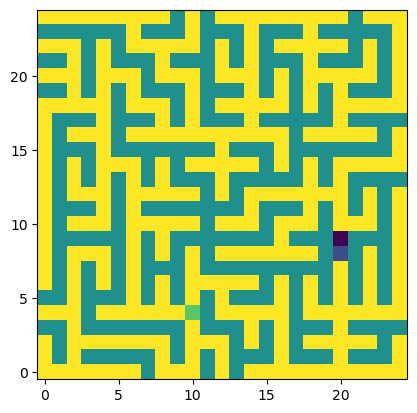

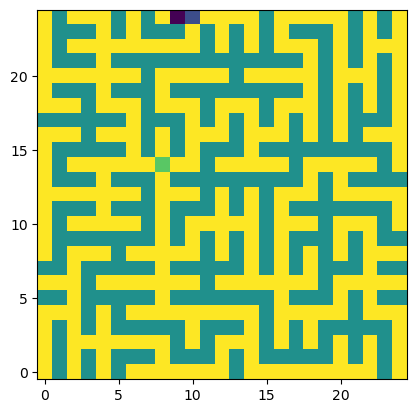

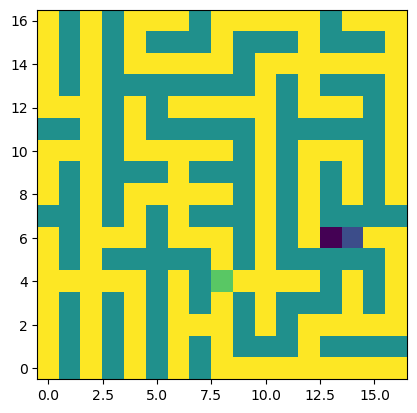

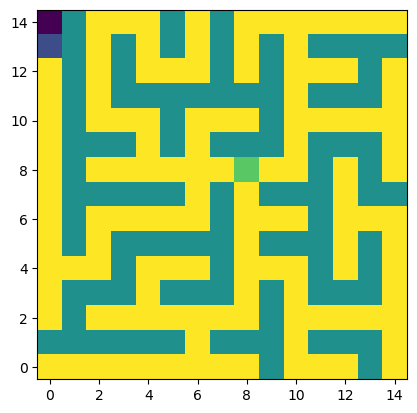

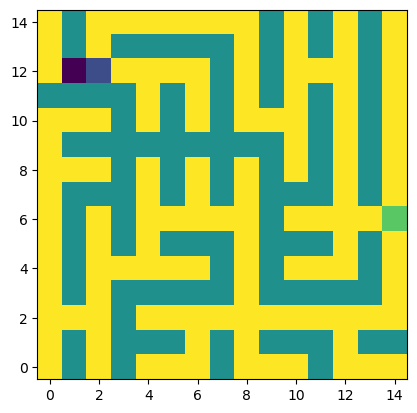

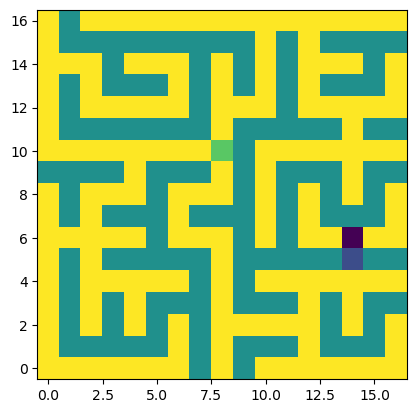

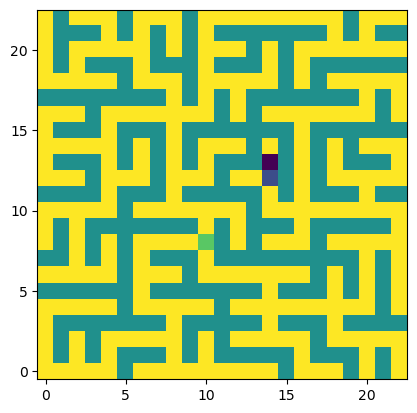

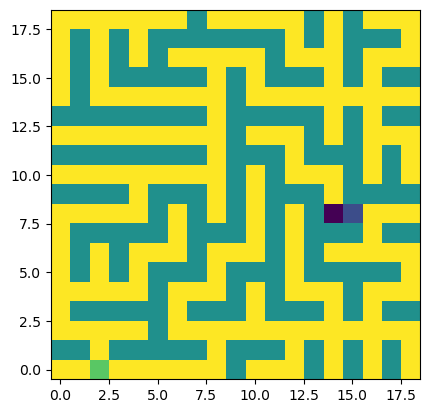

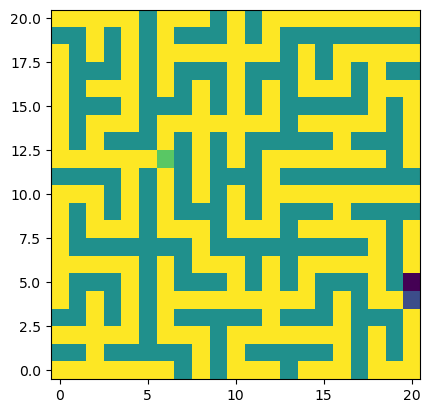

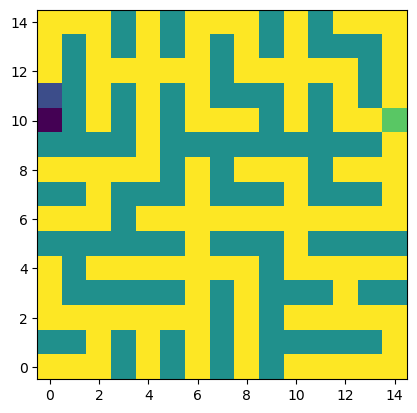

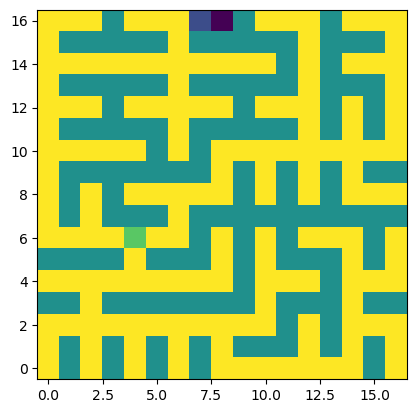

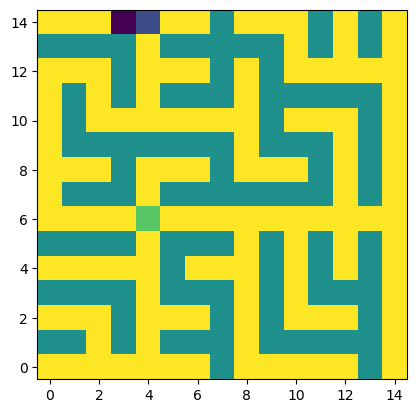

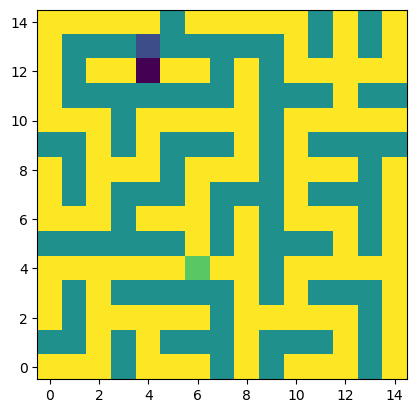

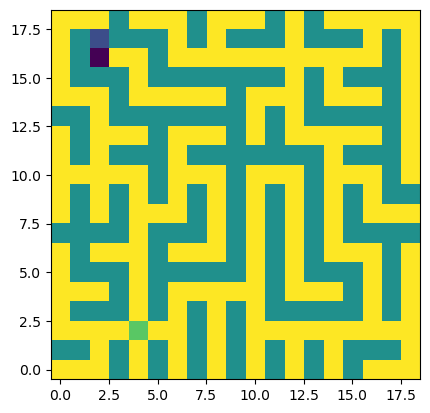

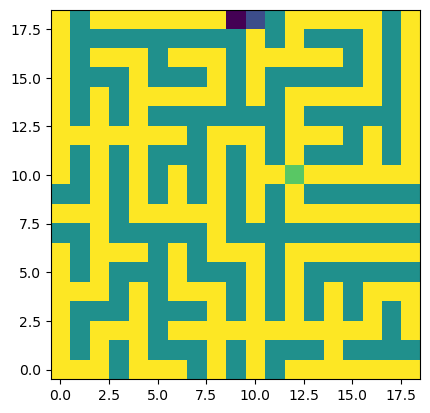

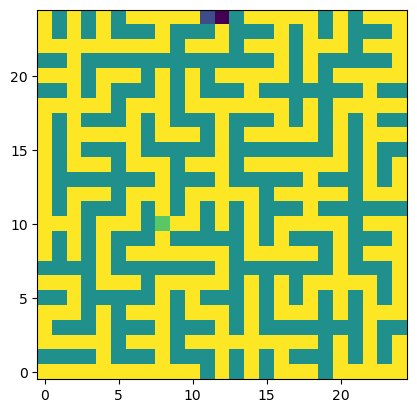

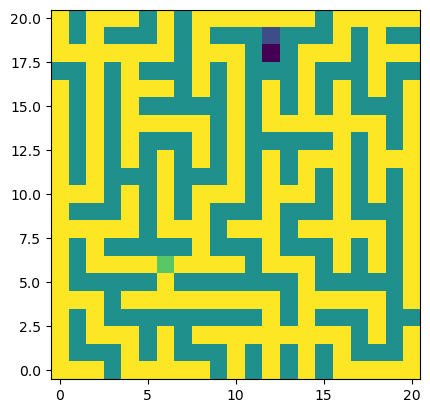

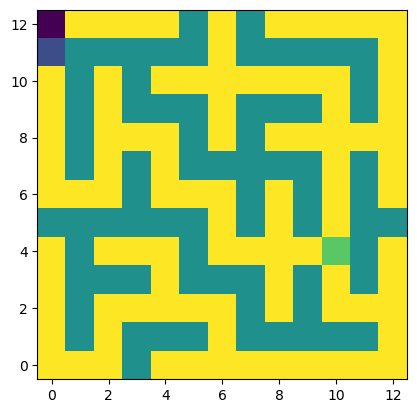

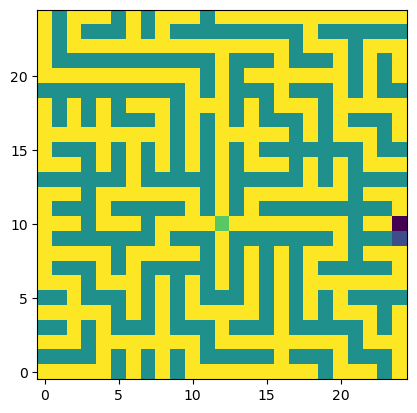

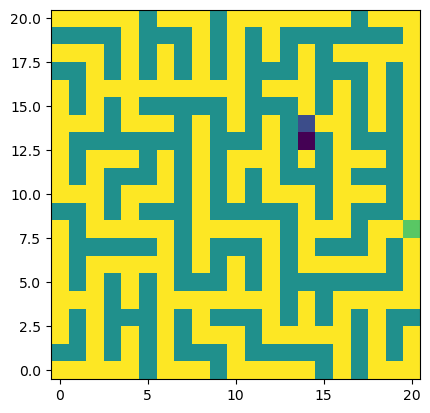

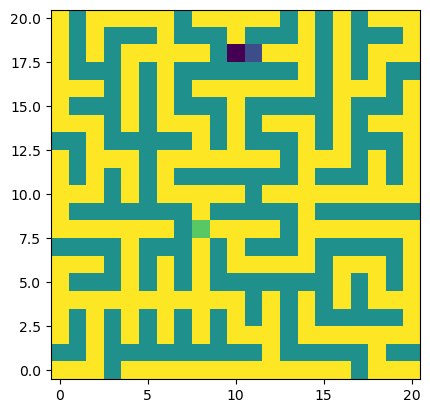

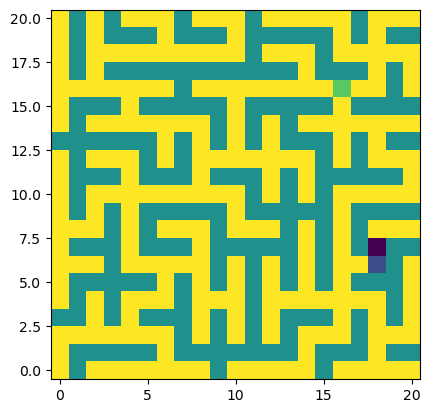

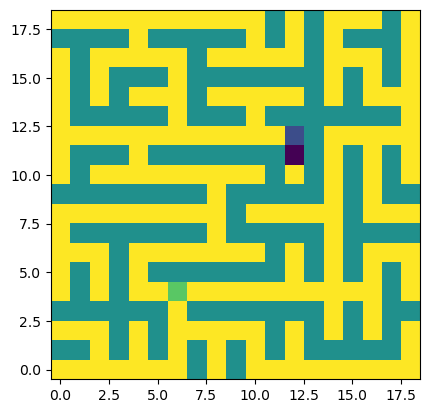

KeyboardInterrupt: 

In [1715]:
# Show mazes where euc_dist_cheese_top_right > x
cond = np.logical_and(
    (recorded_metrics['euc_dist_cheese_decision_square'] > 0),
    (recorded_metrics['steps_between_cheese_decision_square'] > 20),
      
) 

basenum= len (np.nonzero(cond)[0])
cond = np.logical_and(cond,[(runs[i].got_cheese) for i in range(len(runs))])

indexes = np.nonzero(cond)[0]

cheesenum = (len(indexes))

print (basenum)
print (cheesenum)
print (cheesenum/basenum)
for i in indexes:
    g = runs[i].grid(t=-1)
    g[decision_square(g)] = 75
    plt.imshow(g, origin='lower')
    plt.show()

#euc_dist_cheese_decision_square, steps_between_cheese_decision_square, steps_between_cheese_top_right, euc_dist_cheese_top_right,
#euc_dist_decision_square_top_right, steps_between_decision_square_top_right, steps_between_cheese_5x5, 
#steps_between_decision_square_5x5, euc_dist_cheese_5x5, euc_dist_decision_square_5x5

In [ ]:
np.nonzero(recorded_metrics['euc_dist_cheese_top_right'] > 25)

(array([ 54,  55, 159, 161, 295, 399, 400, 535, 536, 561, 576, 584, 698,
        702, 877, 878, 879, 880, 881, 973, 974, 984]),)

## Replay a run

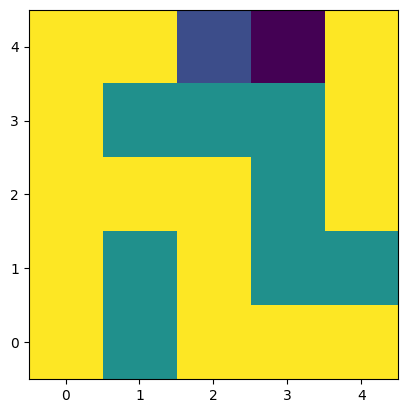

In [ ]:
r = runs[0]
for t in range(0, r.steps):
    grid = r.grid(t)
    plt.imshow(grid, origin='lower')
    display.display(plt.gcf())
    display.clear_output(wait=True)